<a href="https://colab.research.google.com/github/svfrolov/YP-project/blob/main/%E2%84%966_%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B0%D1%80%D0%B8%D1%84%D0%BE%D0%B2%C2%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендация тарифов

# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: `«Смарт»` или `«Ультра»`.

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). 


Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.


**Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до `0.75`. Проверьте `accuracy` на тестовой выборке самостоятельно.**

# Инструкция по выполнению проекта

1. Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет


2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.


3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.


4. Проверьте качество модели на тестовой выборке.


5. Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

# Описание данных

**Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:**


* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
RANDOM_SEED = 54

In [ ]:
df = pd.read_csv("/datasets/users_behavior.csv")

In [ ]:
df.head(10).sort_values('is_ultra')

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
7,15.0,132.40,6.0,21911.60,0
9,90.0,665.41,38.0,17358.61,0
3,106.0,745.53,81.0,8437.39,1
6,57.0,431.64,20.0,3738.90,1
8,7.0,43.39,3.0,2538.67,1


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [ ]:
print('Всего дубликатов =', df.duplicated().sum())

Всего дубликатов = 0


**Пропусков и дубликатов нет**

In [ ]:
df['is_ultra'].unique()

array([0, 1])

In [ ]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


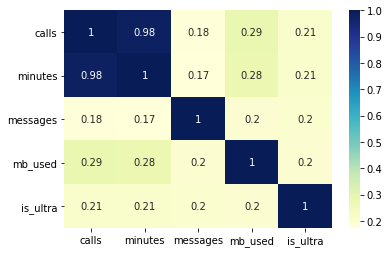

In [ ]:
print(df.corr())
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)  
plt.show()

<b>Удалим звонки, так как в тарифах пакеты минут! </b>

<b>Звонки не имеют значения, между звонками и минутами кор=0,98</b>

<b>Вывод:</b>

1. Данные готовы

2. Дубликатов нет
    
3. Пропусков нет


## Разбейте данные на выборки

In [ ]:
# объявим две переменные

features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [ ]:
(features_train, features_valid, 
 target_train, target_valid) = train_test_split(features, 
                                                target, random_state=12345, stratify=target)

In [ ]:
(features_valid, features_test, 
 target_valid, target_test) = train_test_split(features_valid, 
                                               target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

<b>Размер валидационной выборки:</b>

In [ ]:
print(features_valid.shape)
print(target_valid.shape)

(402, 4)
(402,)


<b>Размер тестовой выборки:</b>

In [ ]:
print(features_test.shape)
print(target_test.shape)

(402, 4)
(402,)


<b>Вывод:</b> \
Обучающий набор данных сохранён в переменных

## Исследуйте модели

### Дерево решений

In [ ]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6):
	model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_train, target_train) # обучим модель
	predictions = model.predict(features_valid) # получим предсказания модели
	result = accuracy_score(target_valid, predictions) # считаем качество модели
	if result < best_result:
		best_model = model
		best_result = result
		best_depth = depth

print("Accuracy лучшей модели:", best_result)
print('Гиперпараметры:', best_model)

Accuracy лучшей модели: 0.7238805970149254
Гиперпараметры: DecisionTreeClassifier(max_depth=1, random_state=54)


### Случайный лес

In [ ]:
best_model = None
best_result_rf = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
	for depth in range (5, 11):
		model = RandomForestClassifier(random_state=12345, max_features=None, n_estimators=est, max_depth=depth) 
		model.fit(features_train, target_train) 
		predictions = model.predict(features_valid) 
		result = accuracy_score(target_valid, predictions)
		if result < best_result_rf:
			best_model = model
			best_result_rf = result
			best_est = est
			best_depth = depth

print("Accuracy лучшей модели:", best_result_rf)
print('Гиперпараметры', best_model)

Accuracy лучшей модели: 0.7810945273631841
Гиперпараметры RandomForestClassifier(max_depth=7, max_features=None, n_estimators=50,
                       random_state=12345)


### Линейная регрессия

In [ ]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=100, solver = 'lbfgs')
model.fit(features_train, target_train)
predictions_valid_l = model.predict(features_valid)

result_l = accuracy_score(predictions_valid_l, target_valid)
print("Accuracy лучшей модели:", result_l)

Accuracy лучшей модели: 0.7437810945273632


### Результаты:

In [ ]:
print("Accuracy лучшей модели DecisionTreeClassifier:", best_result)
print("Accuracy лучшей модели RandomForestClassifier:", best_result_rf)
print("Accuracy лучшей модели LogisticRegression:", result_l)

Accuracy лучшей модели DecisionTreeClassifier: 0.7238805970149254
Accuracy лучшей модели RandomForestClassifier: 0.7810945273631841
Accuracy лучшей модели LogisticRegression: 0.7437810945273632


### Вывод:



1. Accuracy лучшей модели DecisionTreeClassifier: 0.7238805970149254 \
   Гиперпараметры: DecisionTreeClassifier(max_depth=1, random_state=54) \


2. Accuracy лучшей модели RandomForestClassifier: 0.7810945273631841 \
   Гиперпараметры RandomForestClassifier(max_depth=7, max_features=None, n_estimators=50, random_state=12345) \


3. Accuracy лучшей модели LogisticRegression: 0.7437810945273632

**Наиболее лучшие результаты у RandomForestClassifier**

## Проверьте модель на тестовой выборке

<b>Проверим модель случайного леса</b> 

In [ ]:
for depth in range(1, 11):
	model = RandomForestClassifier(random_state=12345, max_depth=depth).fit(features_train, target_train) 
	predictions_t = model.predict(features_test)

	print("max_depth =", depth, ": ", end='')
	print(accuracy_score(target_test, predictions_t))

max_depth = 1 : 0.7661691542288557
max_depth = 2 : 0.8034825870646766
max_depth = 3 : 0.8084577114427861
max_depth = 4 : 0.8034825870646766
max_depth = 5 : 0.8034825870646766
max_depth = 6 : 0.8134328358208955
max_depth = 7 : 0.8233830845771144
max_depth = 8 : 0.8208955223880597
max_depth = 9 : 0.8258706467661692
max_depth = 10 : 0.8233830845771144


In [ ]:
best_result_rf_i = RandomForestClassifier(random_state=12345, 
                                          n_estimators=est, max_depth=depth).fit(features_train, target_train)
predictions_test = model.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print('Accuracy RandomForestClassifier', result_test)

Accuracy RandomForestClassifier 0.8233830845771144


<b>Вывод:</b> 

Accuracy модели RandomForestClassifier на тестовой выборке: 0.8233830845771144

## (бонус) Проверьте модели на адекватность

<b>Модель DummyClassifier</b>

In [ ]:
model_dc = DummyClassifier(random_state=12345)
model_dc.fit(features_train, target_train)
result_dc = model_dc.score(features_valid, target_valid)
print("Accuracy лучшей модели:", result_dc)

Accuracy лучшей модели: 0.6940298507462687


<b>Вывод:</b> 

Модель адекватна

<b>Итоговый вывод:</b> 

1. Данные полные, без пропусков, но пришлось удалить звонки, оставить только минуты из-за корреляции

2. Исследовали три модели DecisionTreeClassifier, RandomForestClassifier, LogisticRegression

3. Лучшей оказалась модель RandomForestClassifier Accuracy

4. На тестовой сборке использовали модель RandomForestClassifier - Accuracy: 0.8233830845771144

5. При проверке на адекватность использовали модель DummyClassifier

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
